In [1]:
!pip install -q geopandas rasterio tqdm IPython matplotlib seaborn tensorflow scikit-learn

In [114]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

import rasterio
from rasterio.plot import show

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.preprocessing import OneHotEncoder

import tensorflow
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


%matplotlib inline

### Carregando dataset

Para fins de organização e não termos que lidar com várias variáveis de dataframes, vou organizá-los em um dicionário chamado `gdfs` para os GeoDataFrames. 

In [2]:
# Variáveis globais
dataset_folder = 'datasets'

paths = {
    'image': os.path.join(dataset_folder, 'AOI_img.tif'),
    'soil': os.path.join(dataset_folder, 'Solo.shp'),
    'vegetation': os.path.join(dataset_folder, 'Veg.shp'), 
    'weeds': os.path.join(dataset_folder, 'Invasoras.shp'),
}

gdfs = {
    'soil': gpd.read_file(paths['soil']),
    'vegetation': gpd.read_file(paths['vegetation']),
    'weeds': gpd.read_file(paths['weeds'])
}

class_names = {0: 'Solo', 1: 'Vegetação', 2: 'Daninhas'}
class_colors = {0: 'sienna', 1: 'mediumseagreen', 2: 'khaki'}

model_path = os.path.join('models', 'classificador_checkpoint.keras')

### Plotando a imagem de estudo

Vamos plotar a imagem da área de estudo e plotar os pontos de amostras

* Solo
* Vegetação
* Ervas daninhas

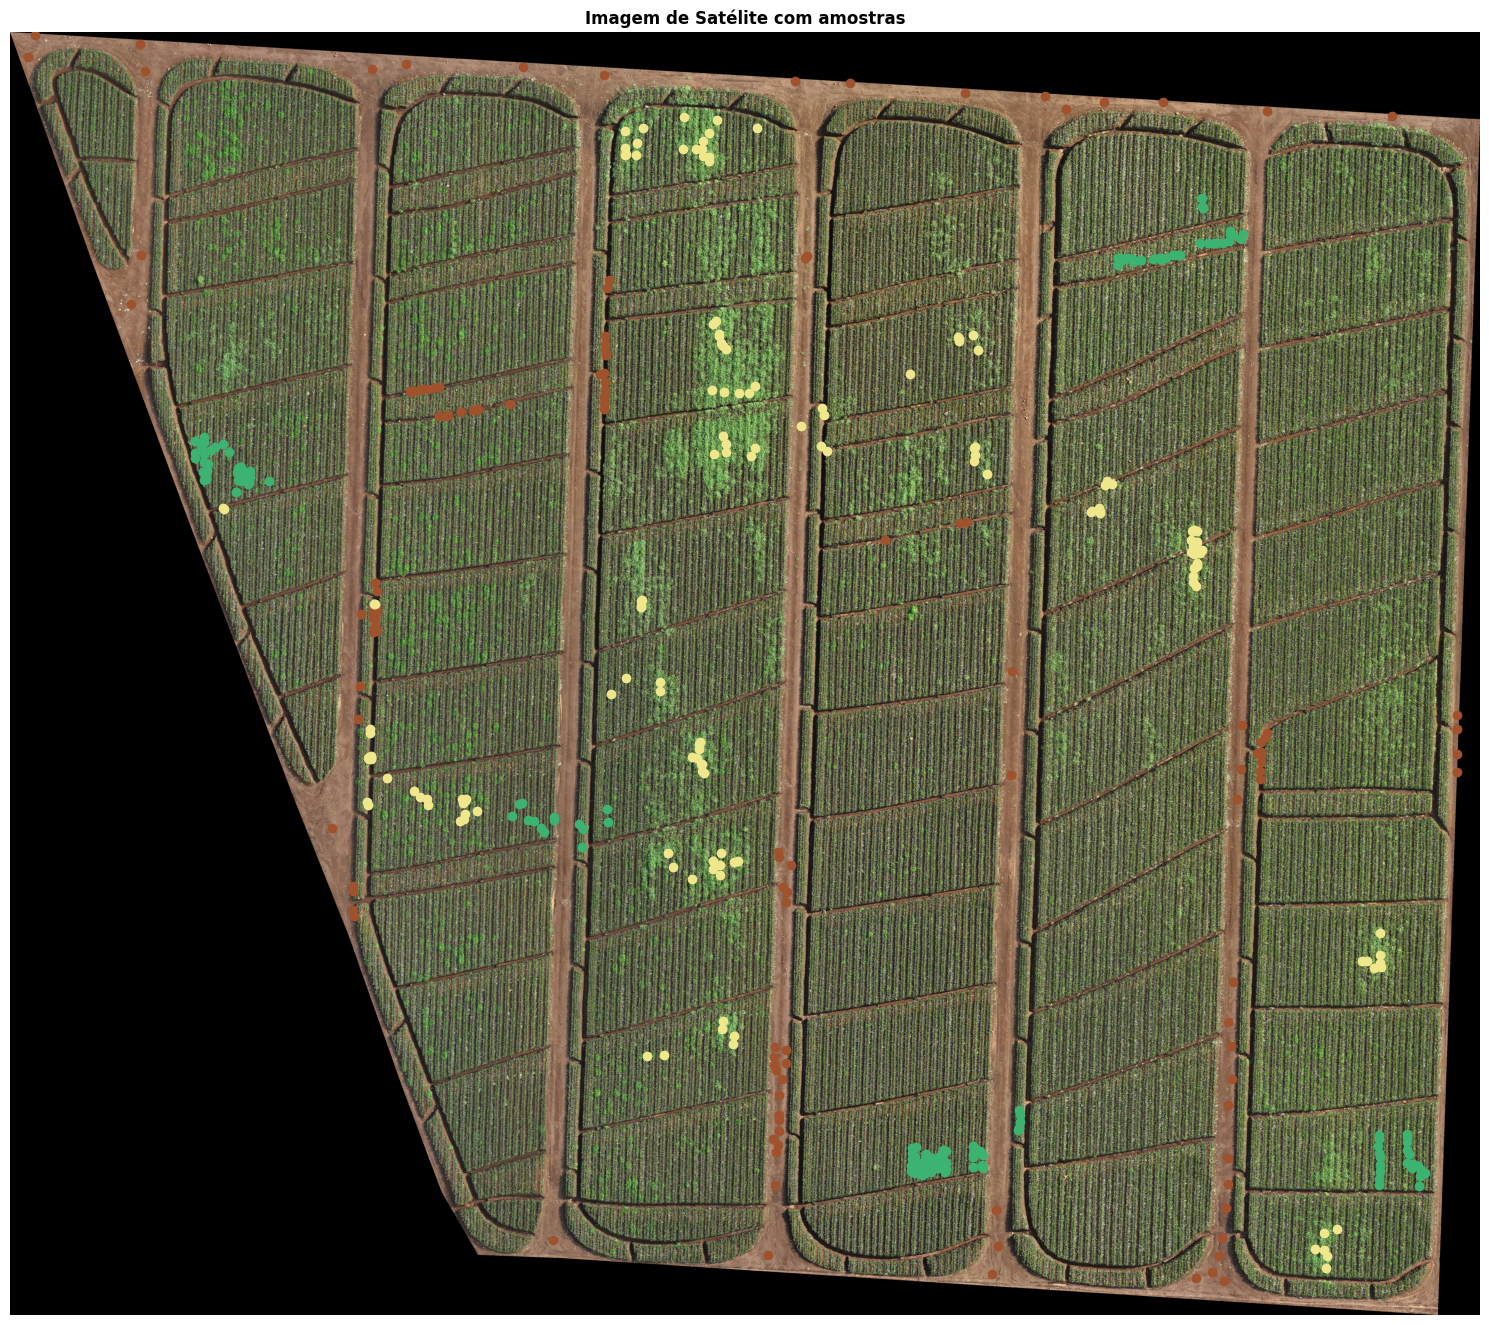

In [3]:
fig, ax = plt.subplots(figsize=(15, 15))
with rasterio.open(paths['image']) as src:
    # Ajusta CRS dos shapefiles
    for name, gdf in gdfs.items():
        gdfs[name] = gdf.to_crs(src.crs.to_dict()) # Converte para cordinates reference system
            
    # Mostra imagem de fundo
    show(src, ax=ax, title='Imagem de Satélite com amostras')
            
    # Plota os pontos de amostras de cada geodataframe
    gdfs['soil'].plot(ax=ax, color='sienna', label='Solo')
    gdfs['vegetation'].plot(ax=ax, color='mediumseagreen', label='Vegetação')
    gdfs['weeds'].plot(ax=ax, color='khaki', label='Ervas Daninhas')
            
    plt.axis('off')
    plt.tight_layout()
    plt.show();

### Preparando dados para treinamento

Para criar um modelo que generalize cores em coordenadas para diferentes classes (solo, vegetação e ervas daninhas), precisamos primeiro:

1. Atribuímos um `class_id` único para cada tipo de amostra, facilitando a identificação posterior
2. Unificamos os geodataframes de todas as amostras em um único conjunto de dados
3. Extraímos as coordenadas geográficas precisas de cada amostra
4. Abrimos a imagem de referência e capturamos os valores RGB dos pixels correspondentes às coordenadas
5. Organizamos os dados em features (valores RGB) e targets (classes)
5. Aplicamos o `train_test_split` da biblioteca Scikit-Learn para separar os conjuntos de treinamento e teste

Este processo nos permitirá treinar um classificador que aprenda a associar padrões de cores a diferentes tipos de cobertura do solo, possibilitando a identificação automática de áreas de interesse em imagens aéreas ou de satélite.

In [4]:
# Adiciona IDs de classe
gdfs['soil']['class_id'] = 0
gdfs['vegetation']['class_id'] = 1
gdfs['weeds']['class_id'] = 2
        
# Combina todos os dados
combined_gdf = pd.concat([
    gdfs['soil'], 
    gdfs['vegetation'], 
    gdfs['weeds'] 
], axis=0)
        
# Extrai coordenadas das amostras
coords = [(x, y) for x, y in zip(combined_gdf.geometry.x, combined_gdf.geometry.y)]

# Extrai os valores RGB dos pixels de cada amostra
with rasterio.open(paths['image']) as src:
    pixel_values = np.array([pixel_value for pixel_value in src.sample(coords)])
        
# Separa features (X) e labels (Y)
X = pixel_values[:, 0:3]  # Usa apenas RGB, ignorando banda Alpha
X = X / 255.0
Y = combined_gdf['class_id'].values.reshape(-1, 1)
        
# Codifica o conjunto de targets para onehot
encoder = OneHotEncoder()
Y_encoded = encoder.fit_transform(Y).toarray()
        
X_train, X_test, y_train, y_test = train_test_split(X, Y_encoded, test_size=0.2, random_state=42)

### Distribuição das classes

Vamos ver se temos uma quantidade equilibrada de amostras de pixels para o treinamento do nosso modelo.

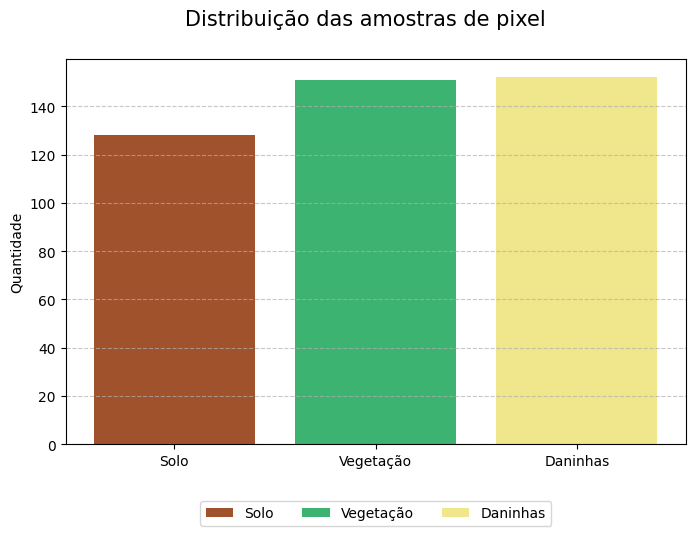

In [5]:
counts = pd.Series(combined_gdf['class_id']).value_counts().sort_index()
counts.index = counts.index.map(class_names.get)

plt.figure(figsize=(8, 5))
plt.bar(counts.index, counts, label=counts.index, color=class_colors.values())
plt.ylabel('Quantidade')
plt.suptitle('Distribuição das amostras de pixel', fontsize=15)
plt.xticks()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.18),
          ncol=3, fancybox=True)
plt.show();

### Construindo o modelo

In [108]:
LEARNING_RATE = 1e-3
BATCH_SIZE = 32 # Batch menor
EPOCHS = 100

model = Sequential([
    Dense(512, activation='elu', kernel_initializer='he_normal', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dense(256, activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(128, activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(64, activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(32, activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(len(class_names), activation='softmax')
])

optimizer = AdamW(learning_rate=LEARNING_RATE, weight_decay=1e-4)

model.compile(
	loss='categorical_crossentropy',
	optimizer=optimizer,
  	metrics=['accuracy']
)

# model.summary()

In [110]:
callbacks = [
    ModelCheckpoint(
        model_path, monitor="val_accuracy", save_best_only=True, mode="max"
    ),
    ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1
    ),
]

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,  # Evitar data leakage
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=callbacks,
)

Epoch 1/100


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 394ms/step - accuracy: 0.5740 - loss: 1.2885 - val_accuracy: 0.3333 - val_loss: 2.6198 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8891 - loss: 0.3227 - val_accuracy: 0.3333 - val_loss: 2.1512 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8897 - loss: 0.2921 - val_accuracy: 0.3623 - val_loss: 1.8588 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9289 - loss: 0.2638 - val_accuracy: 0.3768 - val_loss: 1.6634 - learning_rate: 0.0010
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9183 - loss: 0.2341 - val_accuracy: 0.4203 - val_loss: 1.6548 - learning_rate: 0.0010
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9265 - loss: 0.2229 - val_accuracy: 0.4493 - val_loss: 1.6276 - learning_rate: 0.0010
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9355 - loss: 0.1963 - val_accuracy: 0.4493 - va

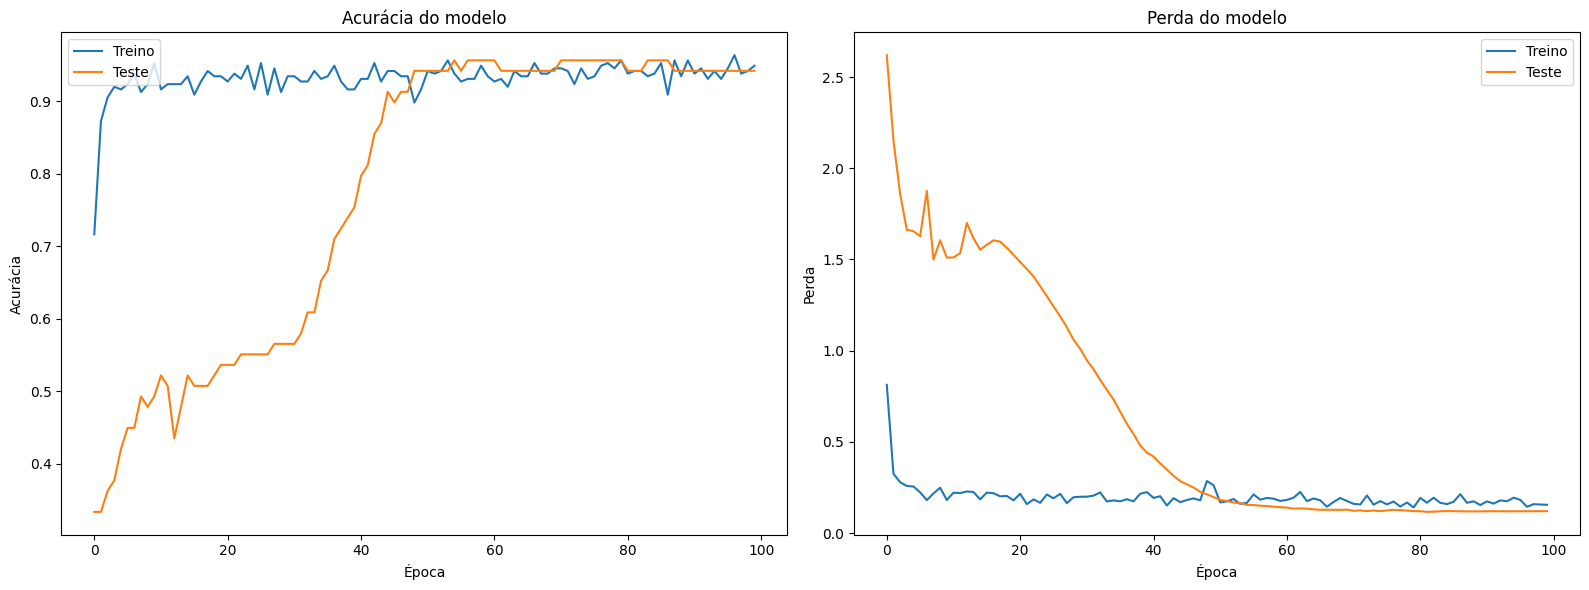

In [111]:
plt.figure(figsize=(16, 6))

# Histórico de acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia do modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Teste'], loc='upper left')

# Histórico de perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perda do modelo')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['Treino', 'Teste'], loc='upper right')

plt.tight_layout()
plt.show()

Para garantir que vamos usar o melhor modelo salvo pelo `ModelCheckpoint` vamos, carregá-lo manualmente, já que na variável `model` pode não estar a melhor versão a que se chegou durante o treinamento.

In [115]:
best_model = load_model(model_path)

In [116]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

Test Loss: 0.1758
Test Accuracy: 0.9540


### Predições e métricas no conjunto de testes

In [117]:
# Pega o conjunto previsto e conjunto verdadeiro
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

get_class_names = np.vectorize(lambda c: class_names[c])

y_pred_classes = get_class_names(y_pred_classes)
y_true_classes = get_class_names(y_true_classes)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step


### Cohen Kappa

In [119]:
kappa = cohen_kappa_score(y_true_classes, y_pred_classes)
print(f'Cohen Kappa Score: {kappa:.4f}')

Cohen Kappa Score: 0.9304


### Resultados

Vamos plotar o relatório de classificação e a matriz de confusão

In [ ]:
def plot_conf_matrix_report(y_pred, y_test):
	plt.figure(figsize=(22, 8))

	# Subplot 1 - Classification Report
	plt.subplot(1, 2, 1)
	plt.title('Classification Report')
	clf_report = classification_report(y_test, y_pred, output_dict=True)
	report_df = pd.DataFrame(clf_report).iloc[:-1, :].T  # Remove 'support'
	sns.heatmap(report_df, annot=True, cmap='coolwarm', fmt='.2f')

	# Subplot 2 - Confusion Matrix
	plt.subplot(1, 2, 2)
	plt.title('Confusion Matrix')
	conf_matrix = confusion_matrix(y_test, y_pred)
	sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
	
	plt.tight_layout()
	plt.show()


plot_conf_matrix_report(y_pred_classes, y_true_classes)

### Classificando imagem completa

In [ ]:
with rasterio.open(paths['image']) as src:
    # Lê a imagem
    img = src.read()
    meta = src.meta.copy()

    # Redimensiona para (height × width × bands)
    img = img.transpose([1, 2, 0])
    original_shape = img.shape

    # Filtra apenas pixels válidos (não pretos & mask == 255)
    valid_mask = img[:, :, 3] == 255
    valid_pixels = img[valid_mask][:, 0:3]  # Apenas RGB
    valid_pixels = valid_pixels / 255.0

    # Faz as predições em lotes para economizar memória
    print(f"Predizendo {len(valid_pixels)} pixels")
    batch_size = 10000
    predictions = []
            
    for i in tqdm(range(0, len(valid_pixels), batch_size)):
        batch = valid_pixels[i:i + batch_size]
        pred = best_model.predict(batch, verbose=0)
        predictions.append(np.argmax(pred, axis=1))
            
    predictions = np.concatenate(predictions)
    

Predizendo 40036037 pixels


100%|██████████| 4004/4004 [40:34<00:00,  1.64it/s]


### Montando matriz de pixels previstos

Agora vamos criar uma matriz cujos valores representam a classe à qual ele pertence (solo, vegetação ou daninha). Note que criamos uma matriz com as mesmas dimensões da imagem original, porém inicializada com valores -1. Em seguida atribuímos as classes preditas para cada pixel válido, ou seja, cuja banda alpha seja 255.

In [ ]:
classified = np.full((original_shape[0], original_shape[1]), -1, dtype=np.int16)
classified[valid_mask] = predictions

# Salvar a matriz para uso posterior
classified_path = os.path.join('outputs', 'classified_pixels')
np.save(classified_path, classified)

### Checkpoint
Caso não queira ou não tenha capacidade computacional para predizer a imagem toda, podemos usar um array numpy contendo as predições

In [ ]:
#classified_path = os.path.join('outputs', 'classified_pixels.npy')
#classified = np.load(classified_path)

Carregando pixels de Solo...
Carregando pixels de Vegetação...
Carregando pixels de Daninhas...


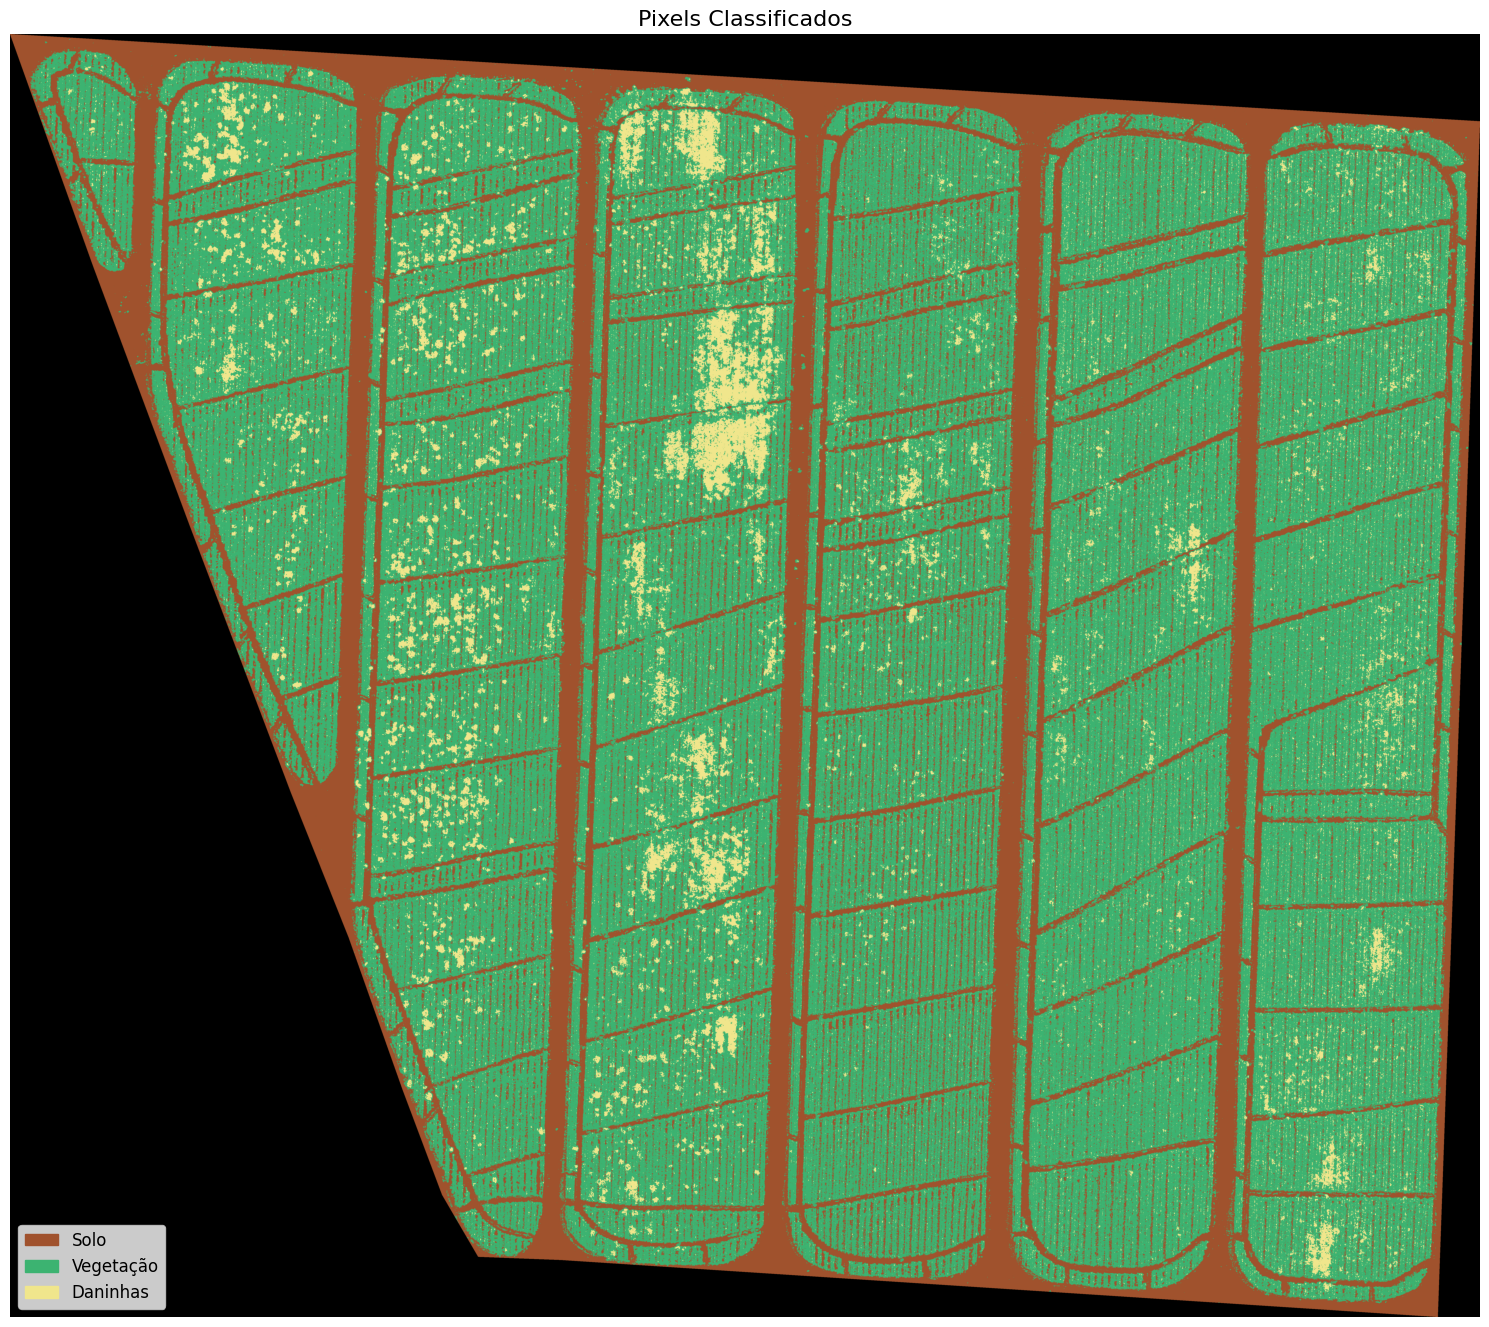

In [7]:
def get_rgb(color: str):
    return tuple(int(x * 255) for x in plt.cm.colors.to_rgba(color)[:3])


# Cria imagem transparente baseada nas classes
colored = np.empty((*classified.shape, 3), dtype=np.uint8)
for class_id, color in class_colors.items():
	print(f'Carregando pixels de {class_names[class_id]}...')
	mask = classified == class_id
	color_rgb = get_rgb(color)
	colored[mask] = color_rgb

plt.figure(figsize=(15, 15))
plt.imshow(colored)
plt.title('Pixels Classificados', fontsize=16)

# Cria legenda
patches = []
for color in class_colors.values():
	color_rgb = get_rgb(color)
	color_rgb = np.array(color_rgb) / 255
	patches.append(plt.Rectangle((0, 0), 1, 1, color=color_rgb))

plt.legend(patches, class_names.values(), loc='lower left', fontsize=12)

plt.axis('off')
plt.tight_layout()
plt.show()

# Salvando a imagem final

In [20]:
# Atualiza metadados
meta.update({
    'driver': 'GTiff',
    'count': 3,
    'dtype': 'uint8',
    'nodata': None,
    'compress': 'lzw'
})
        
# Salva como GeoTIFF
save_path = os.path.join('outputs', 'mapa_classificado.tif')
with rasterio.open(save_path, 'w', **meta) as dst:
    rgb_image = colored.transpose((2, 0, 1))  # de (H, W, 3) → (3, H, W)
    dst.write(rgb_image)
    print('Imagem salva com sucesso!')

Imagem salva com sucesso!


# Estatísticas da lavoura

In [10]:
# Contagem de pixels por classe
unique, counts = np.unique(classified, return_counts=True)
class_counts = dict(zip(unique, counts))

# Exclui a contagem de pixels pretos
del class_counts[-1]

In [13]:
# Conversão de pixels para área (em hectares)
pixel_area_m2 = abs(src.transform[0] * src.transform[4])
pixel_area_ha = pixel_area_m2 / 10_000

area_por_classe_ha = {class_names[cls]: count * pixel_area_ha for cls, count in class_counts.items()}

In [14]:
area_por_classe_ha

{'Solo': np.float64(1.0824965829747573),
 'Vegetação': np.float64(2.6170740628814664),
 'Daninhas': np.float64(0.2188571438743308)}

### Gráfico de distribuição das áreas

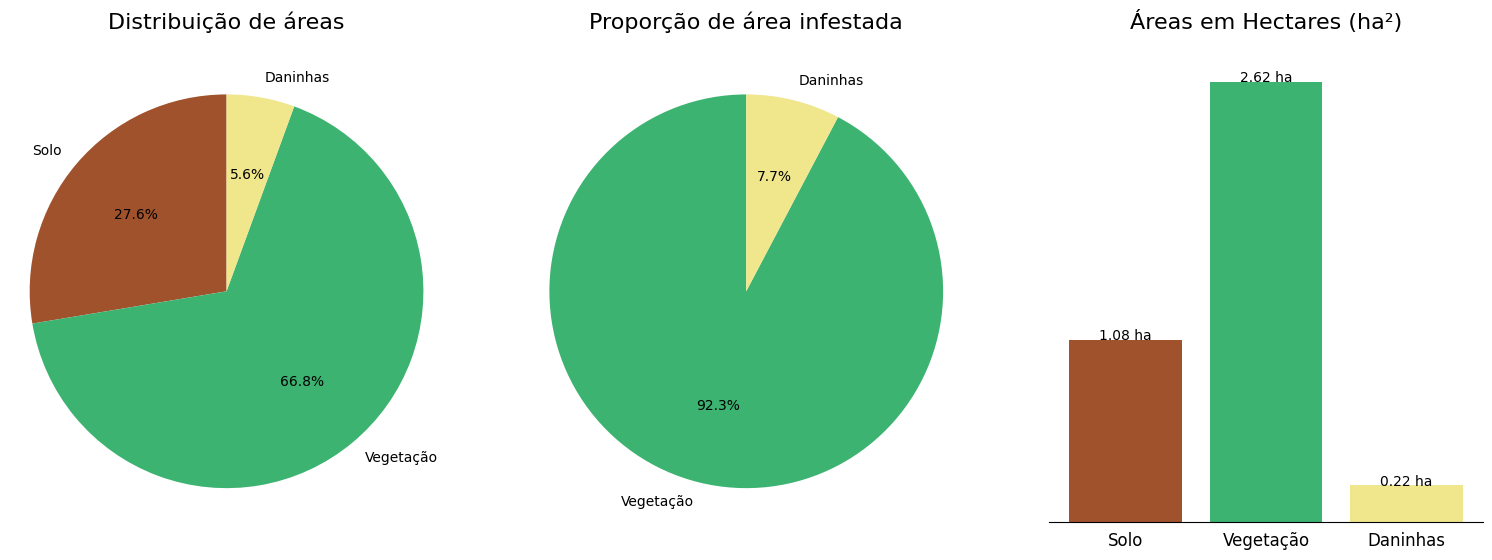

In [60]:
plt.figure(figsize=(19, 6))

plt.subplot(1, 3, 1)
plt.pie(area_por_classe_ha.values(),
        labels=area_por_classe_ha.keys(),
        colors=class_colors.values(),
        autopct='%1.1f%%',
        startangle=90)
plt.title('Distribuição de áreas', y=1.05, fontsize=16)
plt.axis('equal')

plt.subplot(1, 3, 2)
area_infestada_ha = area_por_classe_ha.copy()
del area_infestada_ha['Solo']

plt.pie(area_infestada_ha.values(), 
        labels=area_infestada_ha.keys(), 
    	colors=list(class_colors.values())[1:], 
  		autopct='%1.1f%%', startangle=90)
plt.title('Proporção de área infestada', y=1.05, fontsize=16)
plt.axis('equal')

plt.subplot(1, 3, 3)
plt.bar(area_por_classe_ha.keys(), area_por_classe_ha.values(), color=class_colors.values())
plt.title('Áreas em Hectares (ha²)', y=1.05, fontsize=16)
for i, (label_, value) in enumerate(area_por_classe_ha.items()):
    plt.text(i, value, f"{value:.2f} ha", ha='center')
plt.xticks(fontsize=12)
plt.yticks([]) 
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.tick_params(left=False, bottom=False)


plt.show();